In [2]:
import treecorr
import GCRCatalogs
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import healpy as hp
import camb
import camb.correlations
import matplotlib.colors as clr
%matplotlib inline

In [3]:
def nk_correlation(zlo, zhi):
    nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(100./60)*(np.pi/180))
    
    mask_redshift = (data['redshift']>zlo)*(data['redshift']<zhi) 
    ra0 = data['ra'][mask_redshift]
    dec0 = data['dec'][mask_redshift]
    
    #restrict galaxies to the same octant where we have Kcmb data (in degrees)
    mask_N = (ra0>0)*(ra0<90)*(dec0<0)
    ra_N = ra0[mask_N]
    dec_N = dec0[mask_N]
    
    cat_N = treecorr.Catalog(ra=ra0, dec=dec0, ra_units='deg', dec_units='deg')
    
    nk.process(cat_N, cat_K_cmb)
    xi = nk.xi
    R = np.exp(nk.logr)
    return xi, R

In [4]:
def theory_real_cross(lmax2, z_vals, n_vals, xvals):
    ''' Compute the correlation between galaxy shear and CMB lensing in real space '''
    ns = 0.963
    s8 = .8

    Omega_c = .22
    Omega_b = .0045
    h = 71./100.

    cosmo_ccl = ccl.Cosmology(Omega_c=Omega_c, Omega_b=Omega_b, h=h, sigma8 = s8, n_s = ns)#, transfer_function='boltzmann_class', matter_power_spectrum='emu')
    cmbl1 = ccl.CMBLensingTracer(cosmo_ccl, 1100) # second number is source redshift
    lens1 = ccl.WeakLensingTracer(cosmo_ccl, dndz=(z_vals, n_vals))
    ll = np.arange(lmax2)

    num = ccl.NumberCountsTracer(cosmo_ccl, has_rsd=False, dndz=(z_vals, n_vals), bias = (z_vals,np.ones(len(z_vals))*1.0))
    #cls = ccl.angular_cl(cosmo_ccl, cmbl1, cmbl1, ll)
    cls = ccl.angular_cl(cosmo_ccl, lens1, cmbl1, ll) #k
    cls_num = ccl.angular_cl(cosmo_ccl,num,cmbl1,ll) #nk
    win = hp.pixwin(4096)[:lmax2]
    cls = cls*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals = camb.correlations.cl2corr(pp3_2, cxvals)#from fourier space to real space
    #cls_num = cls_num*win**2
    pp3_2 = np.zeros((lmax2, 4))
    pp3_2[:, 0] = cls_num[:] * (ll * (ll + 1.)) / (2. * np.pi)
    cxvals = np.cos(xvals / (60.) / (180. / np.pi))
    vals2 = camb.correlations.cl2corr(pp3_2, cxvals)
    return xvals, vals[:, 0], vals2[:, 0]

In [29]:
def generate_uniform_random_ra_dec_min_max(n, ra_min, ra_max, dec_min, dec_max):
    """
    Parameters
    ----------
    n : int
        number of random points needed
    ra_min, ra_max, dec_min, dec_max: float
        min and max of ra and dec
    Returns
    -------
    ra : ndarray
        1d array of length n that contains RA in degrees
    dec : ndarray
        1d array of length n that contains Dec in degrees
    """
    ra = np.random.uniform(ra_min, ra_max, size=n)
    dec = np.random.uniform(np.sin(np.deg2rad(dec_min)), np.sin(np.deg2rad(dec_max)), size=n)
    dec = np.arcsin(dec, out=dec)
    dec = np.rad2deg(dec, out=dec)
    return ra, dec

def generate_uniform_random_ra_dec(n):
    """
    Parameters
    ----------
    n : int
        number of random points needed
    Returns
    -------
    ra : ndarray
        1d array of length n that contains RA in degrees
    dec : ndarray
        1d array of length n that contains Dec in degrees
    """
    return generate_uniform_random_ra_dec_min_max(n, 47.5, 75, -25.0, -45.0)

In [6]:
def random_nk(n):
    ra_random, dec_random = generate_uniform_random_ra_dec(int(n))
    cat_random = treecorr.Catalog(ra=ra_random, dec=dec_random, ra_units='deg', dec_units='deg')
    nk = treecorr.NKCorrelation(nbins=20, min_sep=(2.5/60)*(np.pi/180), max_sep=(100./60)*(np.pi/180))
    nk.process(cat_random, cat_K_cmb)
    background = nk.xi
    R_random = np.exp(nk.logr)
    return background, R_random

In [7]:
filename = '/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2/mass_sheets_behind_z3/cmb_maps/cmblensmap_total_gausshiz_masked.fits'

In [8]:
mapfile = hp.read_map(filename)
print(len(mapfile))

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
201326592


In [9]:
index = np.arange(201326592)

In [10]:
theta, phi = hp.pix2ang(nside=4096, ipix=index)
mask_kcmb = (phi>0)*(phi<np.pi/2)*(theta>np.pi/2)
print(True in mask_kcmb)

True


In [11]:
kcmb = mapfile[mask_kcmb]
ra_K = phi[mask_kcmb]
dec_K = np.pi/2-theta[mask_kcmb]

In [12]:
cat_K_cmb = treecorr.Catalog(ra=ra_K, dec=dec_K, k=kcmb, ra_units='rad', dec_units='rad')

In [13]:
gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small')

In [15]:
data = gc.get_quantities(['ra', 'dec', 'convergence', 'redshift'], filters=['mag_i_lsst<22'])
mask = (data['redshift']<1+0.1)*(data['redshift']>1)
print(len(data['ra'][mask]))

16501


In [16]:
redshift = np.linspace(0.5, 3, 6)
print(redshift)

[0.5 1.  1.5 2.  2.5 3. ]


In [17]:
correlation = []
predictionkk = []
predictionnk = []
angsep = []
#for z in redshift:
z=1.0
xi, R = nk_correlation(z, z+0.1)
R = np.degrees(R)
correlation.append(xi)
mask = (data['redshift']<z+0.1)*(data['redshift']>z)
n_vals, z_vals = np.histogram(data['redshift'][mask], bins=100)
z_vals = (z_vals[1:] - z_vals[:-1]) / 2. + z_vals[:-1]
theta, kk, nk = theory_real_cross(10000, z_vals, n_vals, R*60.)
predictionkk.append(kk)
predictionnk.append(nk)
angsep.append(R)
'''
plt.semilogx(R*60, xi, label='NK for '+str(round(z,1))+'<z<'+str(round(z+0.1,1)))
plt.semilogx(R*60, nk, label='prediction')
plt.legend()
plt.xlabel('Angular Separation [arcmin]')
plt.ylabel('NKcmb Correlation')
plt.title('NKcmb Shear Correlation')
#plt.savefig('NKcmb_Correlation.png', dpi=200)
plt.show()
'''

"\nplt.semilogx(R*60, xi, label='NK for '+str(round(z,1))+'<z<'+str(round(z+0.1,1)))\nplt.semilogx(R*60, nk, label='prediction')\nplt.legend()\nplt.xlabel('Angular Separation [arcmin]')\nplt.ylabel('NKcmb Correlation')\nplt.title('NKcmb Shear Correlation')\n#plt.savefig('NKcmb_Correlation.png', dpi=200)\nplt.show()\n"

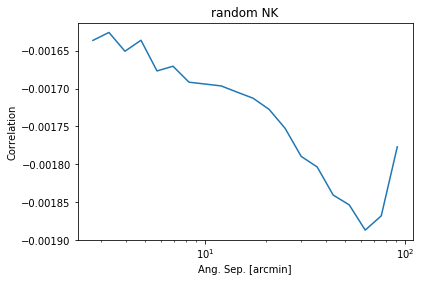

In [30]:
background, R_random = random_nk(1e+6) #calculate NK with random galaxy distribution 
plt.semilogx(np.degrees(R_random)*60, background)
plt.title("random NK")
plt.ylabel("Correlation")
plt.xlabel("Ang. Sep. [arcmin]")
plt.savefig("random_NK.png", dpi=200)
plt.show()

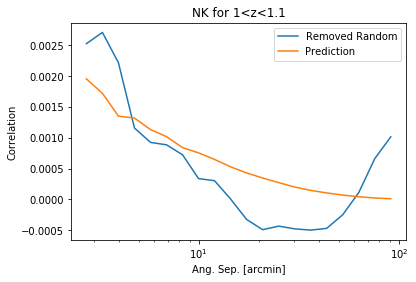

In [31]:
fixed = correlation[0]-background
plt.semilogx(R*60, fixed, label='Removed Random')
plt.semilogx(R*60, predictionnk[i], label='Prediction')
plt.title('NK for 1<z<1.1')
plt.xlabel('Ang. Sep. [arcmin]')
plt.ylabel('Correlation')
plt.legend()
plt.show()